In [1]:
import numpy as np
from astropy.table import vstack,Table,Column,join
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import Image
import ImageOps
plt.rcParams['text.usetex']=True
import urllib, cStringIO

def IR_image(gal):
    
    
    file = cStringIO.StringIO(urllib.urlopen(gal['UKIDSS_url']).read())
    img = Image.open(file)    
    return img
def optical_image(gal):
    
    pixelsize=0.396
    height=424
    width=424

    scale=.02*gal['PETROR90_R']
    # form wurl to query SDSS web sevice to generate cutout image
    cutOutImageUrl="http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx?ra=" + str(gal['RA'])
    cutOutImageUrl += "&dec=" + str(gal['DEC']) + "&scale=""" + str(scale) + "&width=" + str(width)
    cutOutImageUrl += "&height=" + str(height)
    
    file = cStringIO.StringIO(urllib.urlopen(cutOutImageUrl).read())
    img = Image.open(file)    
    return img

In [2]:
data = Table.read('../data/ukidss_gz2_rh_debiased.fits')

In [3]:
#T00: smooth or features?
f_smooth = 't00_smooth_or_features_a0_smooth_debiased_rh_ukidss'
f_features = 't00_smooth_or_features_a1_features_debiased_rh_ukidss'
f_artifact = 't00_smooth_or_features_a2_artifact_debiased_rh_ukidss'

#T07: How rounded is it?
f_completely = 't07_rounded_a0_completely_round_debiased_rh_ukidss'
f_in_between = 't07_rounded_a1_in_between_debiased_rh_ukidss'
f_cigar = 't07_rounded_a2_cigar_shaped_debiased_rh_ukidss'

#T01: Is it edge-on?
f_edgeon = 't01_disk_edge_on_a0_yes_debiased_rh_ukidss'
f_not_edgeon = 't01_disk_edge_on_a1_no_debiased_rh_ukidss'

#T02: bar?
f_bar = 't02_bar_a0_bar_debiased_rh_ukidss'
f_no_bar = 't02_bar_a1_no_bar_debiased_rh_ukidss'

#T08: edgeon bulge shape?
f_rounded_bulge = 't08_bulge_shape_a0_rounded_debiased_rh_ukidss'
f_boxy_bulge = 't08_bulge_shape_a1_boxy_debiased_rh_ukidss'
f_no_bulge = 't08_bulge_shape_a2_no_bulge_debiased_rh_ukidss'

#T03: spiral arms?
f_spiral = 't03_spiral_a0_spiral_debiased_rh_ukidss'
f_nospiral = 't03_spiral_a1_no_spiral_debiased_rh_ukidss'

#T09: arms winding?
f_tight = 't09_arms_winding_a0_tight_debiased_rh_ukidss'
f_medium = 't09_arms_winding_a1_medium_debiased_rh_ukidss'
f_loose = 't09_arms_winding_a2_loose_debiased_rh_ukidss'

#T10: arms number?
f_1 = 't10_arms_number_a0_1_debiased_rh_ukidss'
f_2 = 't10_arms_number_a1_2_debiased_rh_ukidss'
f_3 = 't10_arms_number_a2_3_debiased_rh_ukidss'
f_4 = 't10_arms_number_a3_4_debiased_rh_ukidss'
f_m4 = 't10_arms_number_a4_more_than_4_debiased_rh_ukidss'
f_ct = 't10_arms_number_a5_cant_tell_debiased_rh_ukidss'

#T04: bulge prominence?
f_nb = 't04_bulge_prominence_a0_no_bulge_debiased_rh_ukidss'
f_jn = 't04_bulge_prominence_a1_just_noticeable_debiased_rh_ukidss'
f_obv = 't04_bulge_prominence_a2_obvious_debiased_rh_ukidss'
f_dom = 't04_bulge_prominence_a3_dominant_debiased_rh_ukidss'

In [12]:
data = data[(data['REDSHIFT']<=0.06) & (data['t00_smooth_or_features_count_weighted_ukidss']>30)]
data = data[(data['REDSHIFT']<=0.06) & (data['PETROMAG_MR']<-20)]

In [14]:
len(data)

10086

In [6]:
def sankey_skank(data,c1,c2,c3,c4,c5):
    #All data: Is galaxy smooth/featured? Options: smooth,features,artifact
    smooth = data[(data[f_smooth]>data[f_features]) & (data[f_smooth]>=data[f_artifact])]
    featured = data[(data[f_features]>=data[f_smooth]) & (data[f_features]>=data[f_artifact])]
    artifact = data[(data[f_artifact]>data[f_smooth]) & (data[f_artifact]>data[f_features])]
    print 'smooth/features? [{}] smooth->rounded? {}'.format(len(smooth),c1)
    print 'smooth/features? [{}] featured->edgeon? {}'.format(len(featured),c2)
    print 'smooth/features? [{}] artifact->end'.format(len(artifact))
    
    
    #T07: only applies to smooth. How rounded is it? Options: completely, in between, cigar
    completely = smooth[(smooth[f_completely]>smooth[f_in_between]) & (smooth[f_completely]>=smooth[f_cigar])]
    in_between = smooth[(smooth[f_in_between]>=smooth[f_completely]) & (smooth[f_in_between]>=smooth[f_cigar])]
    cigar = smooth[(smooth[f_cigar]>smooth[f_completely]) & (smooth[f_cigar]>smooth[f_in_between])]
    
    print 'smooth->rounded? [{}] completely {}'.format(len(completely),c1)
    print 'smooth->rounded? [{}] in between {}'.format(len(in_between),c2)
    print 'smooth->rounded? [{}] cigar'.format(len(cigar))

    #T01: only applies to featured 
    edgeon = featured[(featured[f_edgeon]>=featured[f_not_edgeon])]
    notedgeon = featured[(featured[f_not_edgeon]>featured[f_edgeon])]
    
    print 'featured->edgeon? [{}] edge-on->bulge shape? {}'.format(len(edgeon),c1)
    print 'featured->edgeon? [{}] not edge-on->bar?'.format(len(notedgeon))
    
    #T02: bar? only applies to notedgeon
    bar = notedgeon[notedgeon[f_bar]>=notedgeon[f_no_bar]]
    no_bar = notedgeon[notedgeon[f_no_bar]>notedgeon[f_bar]]
    
    print 'not edge-on->bar? [{}] bar->spiral? {}'.format(len(bar),c1)
    print 'not edge-on->bar? [{}] no bar->spiral?'.format(len(no_bar))
    
    #T08 bulge shape? only applies to edgeon
    rounded_bulge = edgeon[(edgeon[f_rounded_bulge]>edgeon[f_boxy_bulge]) & (edgeon[f_rounded_bulge]>=edgeon[f_no_bulge])]
    boxy_bulge = edgeon[(edgeon[f_boxy_bulge]>=edgeon[f_rounded_bulge]) & (edgeon[f_boxy_bulge]>=edgeon[f_no_bulge])]
    no_bulge = edgeon[(edgeon[f_no_bulge]>edgeon[f_rounded_bulge]) & (edgeon[f_no_bulge]>edgeon[f_boxy_bulge])]

    print 'edge-on->bulge shape? [{}] rounded {}'.format(len(rounded_bulge),c1)
    print 'edge-on->bulge shape? [{}] boxy {}'.format(len(boxy_bulge),c2)
    print 'edge-on->bulge shape? [{}] no bulge'.format(len(no_bulge))
    
    #T04 Spiral arms? Applies to bar *and* no bar 
    bar_spiral = bar[bar[f_spiral]>=bar[f_nospiral]]
    bar_nospiral = bar[bar[f_nospiral]>bar[f_spiral]]
    
    print 'bar->spiral? [{}] spiral->arms winding? {}'.format(len(bar_spiral),c1)
    print 'bar->spiral? [{}] no spiral'.format(len(bar_nospiral))
    
    no_bar_spiral = no_bar[no_bar[f_spiral]>=no_bar[f_nospiral]]
    no_bar_nospiral = no_bar[no_bar[f_nospiral]>no_bar[f_spiral]]
    
    print 'no bar->spiral? [{}] spiral->arms winding? {}'.format(len(no_bar_spiral),c1)
    print 'no bar->spiral? [{}] no spiral'.format(len(no_bar_nospiral))
    
    #T09 - arms winding? Applies to all spirals
    spirals = vstack([bar_spiral,no_bar_spiral])
    not_spirals = vstack([bar_nospiral,no_bar_nospiral])

    
    tight = spirals[(spirals[f_tight]>spirals[f_medium]) & (spirals[f_tight]>=spirals[f_loose])]
    medium = spirals[(spirals[f_medium]>=spirals[f_tight]) & (spirals[f_medium]>=spirals[f_loose])]
    loose = spirals[(spirals[f_loose]>spirals[f_tight]) & (spirals[f_loose]>=spirals[f_medium])]
    
    print 'spiral->arms winding? [{}] tight {}'.format(len(tight),c1)
    print 'spiral->arms winding? [{}] medium {}'.format(len(medium),c2)
    print 'spiral->arms winding? [{}] loose'.format(len(loose))

    #T10 - arms number? applies to all spirals.
    
    #first collect into spirals 2
    print 'tight [{}] spirals2->number?'.format(len(tight))
    print 'medium [{}] spirals2->number?'.format(len(medium))
    print 'loose [{}] spirals2->number?'.format(len(loose))
    
    
    one = spirals[(spirals[f_1]>=spirals[f_2])   &  (spirals[f_1]>spirals[f_3]) & (spirals[f_1]>=spirals[f_4]) & (spirals[f_1]>spirals[f_m4]) & (spirals[f_1]>spirals[f_ct])]
    two = spirals[(spirals[f_2]>spirals[f_1])   &  (spirals[f_2]>=spirals[f_3]) & (spirals[f_2]>spirals[f_4]) & (spirals[f_2]>=spirals[f_m4]) & (spirals[f_2]>spirals[f_ct])]
    three = spirals[(spirals[f_3]>=spirals[f_1]) &  (spirals[f_3]>spirals[f_2]) & (spirals[f_3]>=spirals[f_4]) & (spirals[f_3]>=spirals[f_m4]) & (spirals[f_3]>spirals[f_ct])]
    four = spirals[(spirals[f_4]>spirals[f_1])  &  (spirals[f_4]>=spirals[f_2]) & (spirals[f_4]>=spirals[f_3]) & (spirals[f_4]>=spirals[f_m4]) & (spirals[f_4]>spirals[f_ct])]
    m4 = spirals[(spirals[f_m4]>=spirals[f_1])    &  (spirals[f_m4]>spirals[f_2]) & (spirals[f_m4]>spirals[f_3]) & (spirals[f_m4]>spirals[f_4]) & (spirals[f_m4]>spirals[f_ct])]
    ct = spirals[(spirals[f_ct]>=spirals[f_1])    &  (spirals[f_ct]>=spirals[f_2]) & (spirals[f_ct]>=spirals[f_3]) & (spirals[f_ct]>=spirals[f_4]) & (spirals[f_ct]>=spirals[f_m4])]
    
    print 'spirals2->number? [{}] one {}'.format(len(one),c1)
    print 'spirals2->number? [{}] two {}'.format(len(two),c2)
    print 'spirals2->number? [{}] three {}'.format(len(three),c3)
    print 'spirals2->number? [{}] four {}'.format(len(four),c4)
    print 'spirals2->number? [{}] 5+ {}'.format(len(m4),c5)
    print 'spirals2->number? [{}] cant tell'.format(len(ct))
    
    #T04: Bulge prominance, applies to all not edgeon
    
    #first collect all numbered responses and remaining no spirals into notedgeon2
    
    print 'one [{}] bulge prominence'.format(len(one))
    print 'two [{}] bulge prominence'.format(len(two))
    print 'three [{}] bulge prominence'.format(len(three))
    print 'four [{}] bulge prominence'.format(len(four))
    print '5+ [{}] bulge prominence'.format(len(m4))
    print 'cant tell [{}] bulge prominence'.format(len(ct))
    print 'no spiral [{}] bulge prominence {}'.format(len(not_spirals),c1)
    
    nb = notedgeon[(notedgeon[f_nb]>notedgeon[f_jn]) & (notedgeon[f_nb]>notedgeon[f_obv]) * (notedgeon[f_nb]>notedgeon[f_dom])] 
    jn = notedgeon[(notedgeon[f_jn]>=notedgeon[f_nb]) & (notedgeon[f_jn]>notedgeon[f_obv]) * (notedgeon[f_jn]>notedgeon[f_dom])] 
    obv = notedgeon[(notedgeon[f_obv]>=notedgeon[f_nb]) & (notedgeon[f_obv]>=notedgeon[f_jn]) * (notedgeon[f_obv]>notedgeon[f_dom])] 
    dom = notedgeon[(notedgeon[f_dom]>=notedgeon[f_nb]) & (notedgeon[f_dom]>=notedgeon[f_jn]) * (notedgeon[f_dom]>=notedgeon[f_obv])] 
    
    print 'bulge prominence [{}] no bulge {}'.format(len(nb),c1)
    print 'bulge prominence [{}] just noticeable {}'.format(len(jn),c2)
    print 'bulge prominence [{}] obvious'.format(len(obv))
    print 'bulge prominence [{}] dominant {}'.format(len(dom),c3)

In [182]:
sankey_skank(data,'#999999','#1874CD','#27408B','#473C8B','#B0C4DE')

smooth/features? [10668] smooth->rounded? #999999
smooth/features? [4567] featured->edgeon? #1874CD
smooth/features? [598] artifact->end
smooth->rounded? [3444] completely #999999
smooth->rounded? [5974] in between #1874CD
smooth->rounded? [1250] cigar
featured->edgeon? [1801] edge-on->bulge shape? #999999
featured->edgeon? [2766] not edge-on->bar?
not edge-on->bar? [961] bar->spiral? #999999
not edge-on->bar? [1805] no bar->spiral?
edge-on->bulge shape? [1369] rounded #999999
edge-on->bulge shape? [34] boxy #1874CD
edge-on->bulge shape? [398] no bulge
bar->spiral? [846] spiral->arms winding? #999999
bar->spiral? [115] no spiral
no bar->spiral? [1438] spiral->arms winding? #999999
no bar->spiral? [367] no spiral
spiral->arms winding? [719] tight #999999
spiral->arms winding? [905] medium #1874CD
spiral->arms winding? [660] loose
tight [719] spirals2->number?
medium [905] spirals2->number?
loose [660] spirals2->number?
spirals2->number? [70] one #999999
spirals2->number? [1588] two #187

In [8]:

ud_features = 't00_smooth_or_features_a1_features_debiased_rh_ukidss'
gd_features = 't01_smooth_or_features_a02_features_or_disk_debiased_gz2'
u_features = 't00_smooth_or_features_a1_features_weighted_fraction_ukidss'
g_features = 't01_smooth_or_features_a02_features_or_disk_weighted_fraction_gz2'

#edgeon questions
u_edgeon = 't01_disk_edge_on_a0_yes_weighted_fraction_ukidss'
g_edgeon = 't02_edgeon_a04_yes_debiased_gz2'


#spiral arm questions:
u_spiral_arm_count = 't03_spiral_count_weighted_ukidss'
g_spiral_arm_count = 't04_spiral_count_gz2'

g_spiral_arm_yes_frac = 't04_spiral_a08_spiral_weighted_fraction_gz2'
gd_spiral_arm_yes_frac = 't04_spiral_a08_spiral_debiased_gz2'
u_spiral_arm_yes_frac = 't03_spiral_a0_spiral_weighted_fraction_ukidss'
ud_spiral_arm_yes_frac = 't03_spiral_a0_spiral_debiased_rh_ukidss'

u_arms_winding_count = 't09_arms_winding_count_weighted_ukidss'
g_arms_winding_count = 't10_arms_winding_count_gz2'


#ukidss arm winding tight fractions
u_tight_arms = 't09_arms_winding_a0_tight_weighted_fraction_ukidss'
ud_tight_arms = 't09_arms_winding_a0_tight_debiased_rh_ukidss'

#gz2 arm winding tight fractions
g_tight_arms = 't10_arms_winding_a28_tight_weighted_fraction_gz2'
gd_tight_arms = 't10_arms_winding_a28_tight_debiased_gz2'


#obvious bulge fractions
u_obv_bulge = 't04_bulge_prominence_a2_obvious_weighted_fraction_ukidss'
ud_obv_bulge = 't04_bulge_prominence_a2_obvious_debiased_rh_ukidss'
g_obv_bulge = 't05_bulge_prominence_a12_obvious_weighted_fraction_gz2'
gd_obv_bulge = 't05_bulge_prominence_a12_obvious_debiased_gz2'

#dominant bulge fractions 
u_dom_bulge = 't04_bulge_prominence_a3_dominant_weighted_fraction_ukidss'
ud_dom_bulge = 't04_bulge_prominence_a3_dominant_debiased_rh_ukidss'
g_dom_bulge = 't05_bulge_prominence_a13_dominant_weighted_fraction_gz2'
gd_dom_bulge = 't05_bulge_prominence_a13_dominant_debiased_gz2'

In [15]:
#Spiral definition: At least 10 people answer question, and at least 40% detect spiral arms
N_spiral = 10
f_spiral_cut = 0.5
optical_spiral = (data[g_spiral_arm_count]>=N_spiral) & (data[gd_spiral_arm_yes_frac]>f_spiral_cut)
optical_not_spiral_because_N = (data[g_spiral_arm_count]<N_spiral) 
optical_not_spiral_because_f = (data[g_spiral_arm_count]>=N_spiral) & (data[gd_spiral_arm_yes_frac]<f_spiral_cut)

optical_not_spiral = vstack([data[optical_not_spiral_because_N],data[optical_not_spiral_because_f]])

IR_spiral = (data[u_spiral_arm_count]>=N_spiral) & (data[ud_spiral_arm_yes_frac]>f_spiral_cut)

IR_not_spiral_because_N = (data[u_spiral_arm_count]<N_spiral) 
IR_not_spiral_because_f = (data[u_spiral_arm_count]>=N_spiral) & (data[ud_spiral_arm_yes_frac]<f_spiral_cut)

IR_not_spiral = vstack([data[IR_not_spiral_because_N],data[IR_not_spiral_because_f]])


In [16]:
optical_not_IR_spiral = join(data[optical_spiral][['dr7objid']],IR_not_spiral,keys='dr7objid')

In [17]:
len(data[IR_not_spiral_because_f])+len(data[IR_not_spiral_because_N])

7856

In [55]:
2346./len(data[optical_spiral])

0.5255376344086021

In [18]:
len(optical_not_IR_spiral)

1522

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


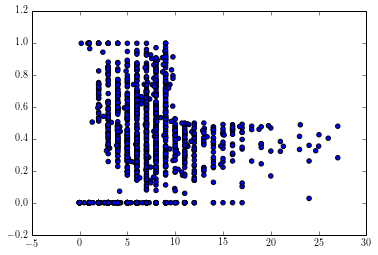

In [19]:
plt.scatter(optical_not_IR_spiral[u_spiral_arm_count],optical_not_IR_spiral[f_spiral])


In [20]:
    data = optical_not_IR_spiral
    c1= 'r'
    c2= 'r'
    c3= 'r'
    c4= 'r'
    c5= 'r'
#All data: Is galaxy smooth/featured? Options: smooth,features,artifact
    smooth = data[(data[f_smooth]>data[f_features]) & (data[f_smooth]>=data[f_artifact])]
    featured = data[(data[f_features]>=data[f_smooth]) & (data[f_features]>=data[f_artifact])]
    artifact = data[(data[f_artifact]>data[f_smooth]) & (data[f_artifact]>data[f_features])]
    print 'smooth/features? [{}] smooth->rounded? {}'.format(len(smooth),c1)
    print 'smooth/features? [{}] featured->edgeon? {}'.format(len(featured),c2)
    print 'smooth/features? [{}] artifact->end'.format(len(artifact))
    
    
    #T07: only applies to smooth. How rounded is it? Options: completely, in between, cigar
    completely = smooth[(smooth[f_completely]>smooth[f_in_between]) & (smooth[f_completely]>=smooth[f_cigar])]
    in_between = smooth[(smooth[f_in_between]>=smooth[f_completely]) & (smooth[f_in_between]>=smooth[f_cigar])]
    cigar = smooth[(smooth[f_cigar]>smooth[f_completely]) & (smooth[f_cigar]>smooth[f_in_between])]
    
    print 'smooth->rounded? [{}] completely {}'.format(len(completely),c1)
    print 'smooth->rounded? [{}] in between {}'.format(len(in_between),c2)
    print 'smooth->rounded? [{}] cigar'.format(len(cigar))

    #T01: only applies to featured 
    edgeon = featured[(featured[f_edgeon]>=featured[f_not_edgeon])]
    notedgeon = featured[(featured[f_not_edgeon]>featured[f_edgeon])]
    
    print 'featured->edgeon? [{}] edge-on->bulge shape? {}'.format(len(edgeon),c1)
    print 'featured->edgeon? [{}] not edge-on->bar?'.format(len(notedgeon))
    
    #T02: bar? only applies to notedgeon
    bar = notedgeon[notedgeon[f_bar]>=notedgeon[f_no_bar]]
    no_bar = notedgeon[notedgeon[f_no_bar]>notedgeon[f_bar]]
    
    print 'not edge-on->bar? [{}] bar->spiral? {}'.format(len(bar),c1)
    print 'not edge-on->bar? [{}] no bar->spiral?'.format(len(no_bar))
    
    #T08 bulge shape? only applies to edgeon
    rounded_bulge = edgeon[(edgeon[f_rounded_bulge]>edgeon[f_boxy_bulge]) & (edgeon[f_rounded_bulge]>=edgeon[f_no_bulge])]
    boxy_bulge = edgeon[(edgeon[f_boxy_bulge]>=edgeon[f_rounded_bulge]) & (edgeon[f_boxy_bulge]>=edgeon[f_no_bulge])]
    no_bulge = edgeon[(edgeon[f_no_bulge]>edgeon[f_rounded_bulge]) & (edgeon[f_no_bulge]>edgeon[f_boxy_bulge])]

    print 'edge-on->bulge shape? [{}] rounded {}'.format(len(rounded_bulge),c1)
    print 'edge-on->bulge shape? [{}] boxy {}'.format(len(boxy_bulge),c2)
    print 'edge-on->bulge shape? [{}] no bulge'.format(len(no_bulge))
    
    #T04 Spiral arms? Applies to bar *and* no bar 
    bar_spiral = bar[bar[f_spiral]>=bar[f_nospiral]]
    bar_nospiral = bar[bar[f_nospiral]>bar[f_spiral]]
    
    print 'bar->spiral? [{}] spiral->arms winding? {}'.format(len(bar_spiral),c1)
    print 'bar->spiral? [{}] no spiral'.format(len(bar_nospiral))
    
    no_bar_spiral = no_bar[no_bar[f_spiral]>=no_bar[f_nospiral]]
    no_bar_nospiral = no_bar[no_bar[f_nospiral]>no_bar[f_spiral]]
    
    print 'no bar->spiral? [{}] spiral->arms winding? {}'.format(len(no_bar_spiral),c1)
    print 'no bar->spiral? [{}] no spiral'.format(len(no_bar_nospiral))
    
    #T09 - arms winding? Applies to all spirals
    spirals = vstack([bar_spiral,no_bar_spiral])
    not_spirals = vstack([bar_nospiral,no_bar_nospiral])

    
    tight = spirals[(spirals[f_tight]>spirals[f_medium]) & (spirals[f_tight]>=spirals[f_loose])]
    medium = spirals[(spirals[f_medium]>=spirals[f_tight]) & (spirals[f_medium]>=spirals[f_loose])]
    loose = spirals[(spirals[f_loose]>spirals[f_tight]) & (spirals[f_loose]>=spirals[f_medium])]
    
    print 'spiral->arms winding? [{}] tight {}'.format(len(tight),c1)
    print 'spiral->arms winding? [{}] medium {}'.format(len(medium),c2)
    print 'spiral->arms winding? [{}] loose'.format(len(loose))

    #T10 - arms number? applies to all spirals.
    
    #first collect into spirals 2
    print 'tight [{}] spirals2->number?'.format(len(tight))
    print 'medium [{}] spirals2->number?'.format(len(medium))
    print 'loose [{}] spirals2->number?'.format(len(loose))
    
    
    one = spirals[(spirals[f_1]>=spirals[f_2])   &  (spirals[f_1]>spirals[f_3]) & (spirals[f_1]>=spirals[f_4]) & (spirals[f_1]>spirals[f_m4]) & (spirals[f_1]>spirals[f_ct])]
    two = spirals[(spirals[f_2]>spirals[f_1])   &  (spirals[f_2]>=spirals[f_3]) & (spirals[f_2]>spirals[f_4]) & (spirals[f_2]>=spirals[f_m4]) & (spirals[f_2]>spirals[f_ct])]
    three = spirals[(spirals[f_3]>=spirals[f_1]) &  (spirals[f_3]>spirals[f_2]) & (spirals[f_3]>=spirals[f_4]) & (spirals[f_3]>=spirals[f_m4]) & (spirals[f_3]>spirals[f_ct])]
    four = spirals[(spirals[f_4]>spirals[f_1])  &  (spirals[f_4]>=spirals[f_2]) & (spirals[f_4]>=spirals[f_3]) & (spirals[f_4]>=spirals[f_m4]) & (spirals[f_4]>spirals[f_ct])]
    m4 = spirals[(spirals[f_m4]>=spirals[f_1])    &  (spirals[f_m4]>spirals[f_2]) & (spirals[f_m4]>spirals[f_3]) & (spirals[f_m4]>spirals[f_4]) & (spirals[f_m4]>spirals[f_ct])]
    ct = spirals[(spirals[f_ct]>=spirals[f_1])    &  (spirals[f_ct]>=spirals[f_2]) & (spirals[f_ct]>=spirals[f_3]) & (spirals[f_ct]>=spirals[f_4]) & (spirals[f_ct]>=spirals[f_m4])]
    
    print 'spirals2->number? [{}] one {}'.format(len(one),c1)
    print 'spirals2->number? [{}] two {}'.format(len(two),c2)
    print 'spirals2->number? [{}] three {}'.format(len(three),c3)
    print 'spirals2->number? [{}] four {}'.format(len(four),c4)
    print 'spirals2->number? [{}] 5+ {}'.format(len(m4),c5)
    print 'spirals2->number? [{}] cant tell'.format(len(ct))
    
    #T04: Bulge prominance, applies to all not edgeon
    
    #first collect all numbered responses and remaining no spirals into notedgeon2
    
    print 'one [{}] bulge prominence'.format(len(one))
    print 'two [{}] bulge prominence'.format(len(two))
    print 'three [{}] bulge prominence'.format(len(three))
    print 'four [{}] bulge prominence'.format(len(four))
    print '5+ [{}] bulge prominence'.format(len(m4))
    print 'cant tell [{}] bulge prominence'.format(len(ct))
    print 'no spiral [{}] bulge prominence {}'.format(len(not_spirals),c1)
    
    nb = notedgeon[(notedgeon[f_nb]>notedgeon[f_jn]) & (notedgeon[f_nb]>notedgeon[f_obv]) * (notedgeon[f_nb]>notedgeon[f_dom])] 
    jn = notedgeon[(notedgeon[f_jn]>=notedgeon[f_nb]) & (notedgeon[f_jn]>notedgeon[f_obv]) * (notedgeon[f_jn]>notedgeon[f_dom])] 
    obv = notedgeon[(notedgeon[f_obv]>=notedgeon[f_nb]) & (notedgeon[f_obv]>=notedgeon[f_jn]) * (notedgeon[f_obv]>notedgeon[f_dom])] 
    dom = notedgeon[(notedgeon[f_dom]>=notedgeon[f_nb]) & (notedgeon[f_dom]>=notedgeon[f_jn]) * (notedgeon[f_dom]>=notedgeon[f_obv])] 
    
    print 'bulge prominence [{}] no bulge {}'.format(len(nb),c1)
    print 'bulge prominence [{}] just noticeable {}'.format(len(jn),c2)
    print 'bulge prominence [{}] obvious'.format(len(obv))
    print 'bulge prominence [{}] dominant {}'.format(len(dom),c3)

smooth/features? [1125] smooth->rounded? r
smooth/features? [342] featured->edgeon? r
smooth/features? [55] artifact->end
smooth->rounded? [365] completely r
smooth->rounded? [688] in between r
smooth->rounded? [72] cigar
featured->edgeon? [116] edge-on->bulge shape? r
featured->edgeon? [226] not edge-on->bar?
not edge-on->bar? [58] bar->spiral? r
not edge-on->bar? [168] no bar->spiral?
edge-on->bulge shape? [104] rounded r
edge-on->bulge shape? [0] boxy r
edge-on->bulge shape? [12] no bulge
bar->spiral? [16] spiral->arms winding? r
bar->spiral? [42] no spiral
no bar->spiral? [40] spiral->arms winding? r
no bar->spiral? [128] no spiral
spiral->arms winding? [24] tight r
spiral->arms winding? [13] medium r
spiral->arms winding? [19] loose
tight [24] spirals2->number?
medium [13] spirals2->number?
loose [19] spirals2->number?
spirals2->number? [2] one r
spirals2->number? [29] two r
spirals2->number? [0] three r
spirals2->number? [0] four r
spirals2->number? [0] 5+ r
spirals2->number? [25

## Four groups of SONIs to look at:
## 1) Classified as elliptical = smooth
## 2) Featured, not edge-on = notedgeon
## 3) Featured, edge-on = edgeon 
## 4) Star/artifact = artifact

In [21]:
from scipy import ndimage
from random import shuffle


In [22]:
def random_list(data):
    list_n = np.linspace(0,len(data)-1,len(data))
    shuffle(list_n)
    list_n = [int(n) for n in list_n]
    return list_n

In [47]:
datas = artifact
datas_n = random_list(datas)

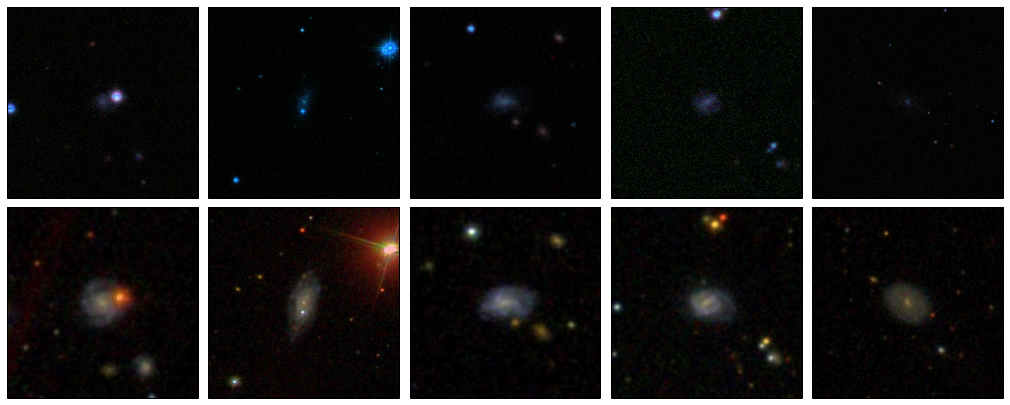

In [49]:
f=plt.figure(figsize=(18,7))
gs = gridspec.GridSpec(2,5)
gs.update(hspace=.05,wspace=.01)
for i in range(0,5):
    gal = datas[datas_n[i]]
    ax = plt.subplot(gs[0,i]) #top row: optical
    img = IR_image(gal)
    if i==0:
        rotimg = ndimage.rotate(img,270)
        plt.imshow(rotimg,origin='lower')
    if i==1:
        rotimg = ndimage.rotate(img,90)
        plt.imshow(rotimg,origin='lower')
    if i==2:
        rotimg = ndimage.rotate(img,270)
        plt.imshow(rotimg,origin='lower')
    if i==3:
        rotimg = ndimage.rotate(img,270)
        plt.imshow(rotimg,origin='lower')
    if i==4:
        rotimg = ndimage.rotate(img,90)
        plt.imshow(rotimg,origin='lower')
    plt.tick_params(labelbottom='off',labelleft='off')

    ax = plt.subplot(gs[1,i]) #bottom row: IR
    img = optical_image(gal)
    plt.imshow(img)
    plt.tick_params(labelbottom='off',labelleft='off')
plt.savefig('/home/mel/Documents/thesis/figures/artifact_sonis.pdf')

In [4]:
def get_fractions(numbers):
    for n in numbers:
        frac = float(n)/np.sum(numbers)
        print '{} = {:.2f}'.format(n,frac)

In [17]:
get_fractions([5,37,95,18])

5 = 0.03
37 = 0.24
95 = 0.61
18 = 0.12


(array([ 4.85372993,  2.23271577,  1.26196978,  1.65026818,  1.26196978,
         0.58244759,  0.87367139,  0.48537299,  0.2912238 ,  0.2912238 ]),
 array([ 0.        ,  0.07254476,  0.14508952,  0.21763428,  0.29017904,
         0.3627238 ,  0.43526856,  0.50781332,  0.58035809,  0.65290285,
         0.72544761]),
 <a list of 1 Patch objects>)

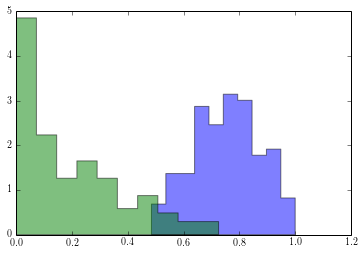

In [46]:
plt.hist(edgeon[u_edgeon],histtype='stepfilled',alpha=.5,normed=True)
plt.hist(edgeon[g_edgeon],histtype='stepfilled',alpha=.5,normed=True)

In [39]:
4*12

48